In [83]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

data = pd.read_csv("initial_analysis_2018cycle_posdig.csv", sep='|')

In [84]:
data.head()
data.shape

cmte_id amndt_ind rpt_tp transaction_pgi   image_num transaction_tp  \
0  C00529693         N     YE           P2018    61074816            24Z   
1  C00111278         A    30G           R2018  1865218414            24Z   
2  C00000935         A     M8           G2018  1649176053            24Z   
3  C00362178         N     YE           G2018   390518681            24Z   
4  C00637504         A     Q3           G2018 -1609304497            24Z   

  entity_tp                 name        city state  ...  occupation  \
0       ORG       DELTA AIRLINES     ATLANTA    GA  ...         NaN   
1       ORG    AMERICAN AIRLINES   FT. WORTH    TX  ...         NaN   
2       ORG  D STREET EVENTS LLC  WASHINGTON    DC  ...         NaN   
3       ORG             METROTEC  CHARLESTON    SC  ...         NaN   
4       ORG   HAWKEYE RESTAURANT      KEOKUK    IA  ...         NaN   

   transaction_dt  transaction_amt   other_id      tran_id file_num memo_cd  \
0         8312017            417.0  C00285171  VNGY6A9JWE1  1205190     NaN   
1        11142018            886.0  C00675348  SB23.9879.0  1308558       X   
2         7312018             37.0  C00653816  SB23-976681  1263580     NaN   
3        11282018           1223.0  C00634808    SB23.4441  1310347       X   
4         9302018             44.0  C00650440  VTDPKAADD97  1295168     NaN   

   memo_text               sub_id amt_first_digit  
0        NaN  4021420181504639317               4  
1        NaN  4021220191639167936               8  
2        NaN  4092620181592391265               3  
3        NaN  4022520191643651087               1  
4        NaN  4121220181621338569               4  

[5 rows x 22 columns]

(4771, 22)

In [85]:
data['transaction_amt'].describe()

count     4771.000000
mean       584.712639
std       1520.254859
min          1.000000
25%         33.000000
50%        160.000000
75%        634.000000
max      50000.000000
Name: transaction_amt, dtype: float64

In [86]:
# Recast amt_first_digit from text to integer
first_digits = data.loc[:,'amt_first_digit'].astype(int)
first_digits.describe()

count    4771.000000
mean        3.186753
std         2.374771
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max         9.000000
Name: amt_first_digit, dtype: float64

In [87]:
# Now I need to report the frequencies of each of the amt_first digits
# First, get the counts of each digit from 0 through 9
first_digits.hist()
# I wish I could get the histogram for Benford's law data

<AxesSubplot:>

In [88]:
first_digit_counts = first_digits.value_counts()
first_digit_counts
first_digit_counts.keys()

1    1618
2     894
3     584
4     416
5     351
6     278
7     260
8     191
9     179
Name: amt_first_digit, dtype: int64

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [89]:
# Now get the total number of rows
total_rows = len(data)
first_digit_freq = first_digit_counts/total_rows

In [90]:
# Create Benford's limiting order distribution as a series
benfordd = pd.Series([0.30103,0.17609, 0.12494, 0.09691, 0.07918, 0.06995, 0.05799, 0.05115, 0.04576], index=range(1,10))

# [Goodness of Fit Tests](https://www.statisticshowto.com/goodness-of-fit-test/)
## [Chi-Squared Test](https://www.statisticshowto.com/probability-and-statistics/chi-square/)
First, I need to use the total number of rows to calculate the expected number of counts for each digit from Benford's distribution (expected) and compare it to first_digit_counts (observed).
The null hypothesis is that the 2018 cycle campaign finance data does follow Benford's distribution. <br>
The alternative hypothesis is that the 2018 cycle campaign finance data does not follow Benford's distributino.

In [91]:
import scipy.stats as stats

In [92]:
nrows = data.shape[0]
expected = benfordd*nrows

In [93]:
# source: https://stackoverflow.com/questions/27663924/printing-2-evenly-populated-lists-side-by-side-evenly/27663989
fmt = '{:<8}{:<20}{}'

print(fmt.format('', 'Expected', 'Observed'))
for i, (ben, cyc) in enumerate(zip(expected, first_digit_counts)):
    print(fmt.format(i, ben, cyc))

        Expected            Observed
0       1436.21413          1618
1       840.12539           894
2       596.08874           584
3       462.35760999999997  416
4       377.76778           351
5       333.73145           278
6       276.67029           260
7       244.03665           191
8       218.32096           179


In [94]:
stats.chisquare(f_obs=first_digit_counts, f_exp=expected)

Power_divergenceResult(statistic=62.173576438750885, pvalue=1.7429974764071745e-10)

The Chi-squared statistic is 62.17 and the corresponding p-value is 1.74e-10 (basically zero). Since the p-value is less than 0.05, we reject the null hypothesis and claim that the 2018 cycle data do not follow Benford's distribution.
I need to come back and double check this!! It's very odd that the p-value is low when it appears to fit Benford's distribution so well. I should read stats.chisquare documentation more, check that my degrees of freedom are correct, and/or look at [this post](https://stackoverflow.com/questions/42888962/chi-squared-goodness-of-fit-test-in-python-way-too-low-p-values-but-the-fittin) <br>
Ahh, I should come back to it after I have all the proper data. According to Cho & Gaines on p. 220 "$\chi^2$ tests are very sensitive to sample size, having enormous power for large *N*, so that even quite small differences will be statistically significant. This test appears to be too rigid to assess goodness-of-fit well, especially since the Benford proportions do not represent a true distribution that one would expect to occur in the limit (Ley 1996; Giles 2007)."

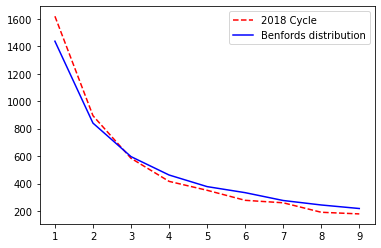

In [95]:
fig, ax = plt.subplots()
ax.plot(first_digit_counts, '--r', label='2018 Cycle')
ax.plot(expected, '-b', label='Benford''s distribution')
leg = ax.legend()

In [96]:
first_digit_freq

1    0.339132
2    0.187382
3    0.122406
4    0.087193
5    0.073569
6    0.058269
7    0.054496
8    0.040034
9    0.037518
Name: amt_first_digit, dtype: float64